In [1]:
from tqdm import tqdm
from glob import glob
import os
import torch as pt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from kneed import KneeLocator

from utils.structure import StructuresDataset, concatenate_chains
from utils.data_encoding import encode_structure, mean_coordinates, encode_features, extract_topology, extract_dynamic_features, pool_to_res_level
from build_dataset import extract_all_contacts, pack_dataset_items
from utils.configs import config_dataset

In [2]:
#device = ("cuda" if pt.cuda.is_available() else "cpu")
device = 'cpu'

In [3]:
from utils.structure import read_pdb, clean_structure, tag_hetatm_chains, split_by_chain, filter_non_atomic_subunits, remove_duplicate_tagged_subunits, reorganize_structure, concatenate_chains
structure = read_pdb('data/6wa1.pdb')
structure = clean_structure(structure, rm_wat=True)
structure = tag_hetatm_chains(structure)
subunits = split_by_chain(structure)
subunits = filter_non_atomic_subunits(subunits)
subunits = remove_duplicate_tagged_subunits(subunits)
subunits = reorganize_structure(subunits)
contacts = extract_all_contacts(subunits, 5.0)
structures_data, contacts_data = pack_dataset_items(
                subunits, contacts,
                config_dataset['molecule_ids'],
                config_dataset['max_num_nn'], device=device
            )
# structures_data
contacts_data['A']['B']
# subunits.keys()

({'Y': array([[15, 90,  5, 11],
         [18, 92, 14, 15],
         [51, 93, 14, 11],
         [52, 92, 13, 15],
         [52, 93, 13, 11],
         [53, 90, 17, 11],
         [53, 91, 17, 14],
         [53, 92, 17, 15],
         [53, 93, 17, 11],
         [54, 90,  6, 11],
         [54, 91,  6, 14],
         [55, 89, 11,  0],
         [55, 90, 11, 11],
         [55, 91, 11, 14],
         [56, 59,  9,  6],
         [56, 88,  9, 11],
         [56, 89,  9,  0],
         [56, 90,  9, 11],
         [56, 91,  9, 14],
         [57, 88,  5, 11],
         [57, 89,  5,  0],
         [58, 88, 13, 11],
         [59, 56,  6,  9],
         [59, 59,  6,  6],
         [59, 88,  6, 11],
         [67, 93,  0, 11],
         [85, 88,  6, 11],
         [86, 86, 18, 18],
         [86, 88, 18, 11],
         [87, 88, 10, 11],
         [88, 56, 11,  9],
         [88, 57, 11,  5],
         [88, 58, 11, 13],
         [88, 59, 11,  6],
         [88, 85, 11,  6],
         [88, 86, 11, 18],
         [88, 87, 11, 1

In [10]:
'+'.join(list(map(lambda x: str(x),contacts_data['A']['B'][0]['Y'][:,1])))

'90+92+93+92+93+90+91+92+93+90+91+89+90+91+59+88+89+90+91+88+89+88+56+59+88+93+88+86+88+88+56+57+58+59+85+86+87+88+55+56+57+15+53+54+55+56+53+54+55+56+18+52+53+51+52+53+67'

In [4]:
# find pdb files and ignore already predicted oins
pdb_filepaths = glob(os.path.join("/home/omokhtar/Desktop/Codes/data", "*.pdb"), recursive=True)
pdb_filepaths = [fp for fp in pdb_filepaths if "_i" not in fp]

# create dataset loader with preprocessing. The output format: pdb -> {chain{conformer{attributes}}}
dataset = StructuresDataset(pdb_filepaths, with_preprocessing=True)

# debug print
for pdb_dic, file_path in dataset:
    print (file_path)

/home/omokhtar/Desktop/Codes/data/2apn.pdb
/home/omokhtar/Desktop/Codes/data/6wa1.pdb
/home/omokhtar/Desktop/Codes/data/1a2s.pdb


In [5]:
dataset[0][0]

{'A': {0: {'xyz': array([[-27.019, -10.551,  -5.075],
          [-25.534, -10.567,  -4.995],
          [-25.058, -10.688,  -3.552],
          ...,
          [ 15.003,   6.764, -15.906],
          [ 16.423,   7.228, -18.492],
          [ 14.596,  11.154, -16.835]], dtype=float32),
   'name': array(['N', 'CA', 'C', 'O', 'CB', 'CG', 'SD', 'CE', 'N', 'CA', 'C', 'O',
          'CB', 'CG1', 'CG2', 'CD1', 'N', 'CA', 'C', 'O', 'CB', 'CG', 'OD1',
          'OD2', 'N', 'CA', 'C', 'O', 'CB', 'CG', 'OD1', 'OD2', 'N', 'CA',
          'C', 'O', 'CB', 'CG', 'SD', 'CE', 'N', 'CA', 'C', 'O', 'CB', 'N',
          'CA', 'C', 'O', 'CB', 'CG1', 'CG2', 'N', 'CA', 'C', 'O', 'CB',
          'CG', 'CD', 'N', 'CA', 'C', 'O', 'CB', 'CG', 'CD1', 'CD2', 'N',
          'CA', 'C', 'O', 'CB', 'OG1', 'CG2', 'N', 'CA', 'C', 'O', 'CB',
          'CG', 'CD1', 'CD2', 'CE1', 'CE2', 'CZ', 'N', 'CA', 'C', 'O', 'CB',
          'OG1', 'CG2', 'N', 'CA', 'C', 'O', 'CB', 'CG', 'OD1', 'OD2', 'N',
          'CA', 'C', 'O', 'CB', 'N

The format after concatenation is a **dictionary** for each PDB file. The keys include:
1. `conformer_chain_residue_atom` - Represents the combination information of each atom;
    1. Which conformer? 
    2. Chain name?
2. `xyz` - Contains the xyz coordinates of each atom.
3. `element name` - Specifies the name of the element.
4. `resID` - The residue ID of each atom.
5. ... and other relevant keys.


In [6]:
# run model on all subunits
with pt.no_grad():
    for pdb, filepath in tqdm(dataset): #iterate over chains
        if '2apn' not in filepath: continue
        print (pdb['A'][0]['resname'])
        # concatenate all chains together
        pdb = concatenate_chains(pdb)
        ID = pdb['ID']
        
        # make xyz (X) and resid (M) Tensors (M shape is a boolean matrix of size len(atom)*len(unique res),showing which atoms belong to the same residue which is later used for pooling from atom-level to residue level)
        X, M = encode_structure(pdb, ID, device=pt.device(device))
        Xm = mean_coordinates(X,ID)
        # onehot encoding of 30 element types
        q,_,_ = encode_features(pdb, ID)
        
        # extract topology (specific to single chain)
        ids_topk, _, _, _, _ = extract_topology(X, ID, 64)
        
        # extract dynamic features (chain specific and atom level)
        dccm, rmsf = extract_dynamic_features(X, ID)


  0%|                                                     | 0/3 [00:00<?, ?it/s]

['MET' 'MET' 'MET' 'MET' 'MET' 'MET' 'MET' 'MET' 'ILE' 'ILE' 'ILE' 'ILE'
 'ILE' 'ILE' 'ILE' 'ILE' 'ASP' 'ASP' 'ASP' 'ASP' 'ASP' 'ASP' 'ASP' 'ASP'
 'ASP' 'ASP' 'ASP' 'ASP' 'ASP' 'ASP' 'ASP' 'ASP' 'MET' 'MET' 'MET' 'MET'
 'MET' 'MET' 'MET' 'MET' 'ALA' 'ALA' 'ALA' 'ALA' 'ALA' 'VAL' 'VAL' 'VAL'
 'VAL' 'VAL' 'VAL' 'VAL' 'PRO' 'PRO' 'PRO' 'PRO' 'PRO' 'PRO' 'PRO' 'LEU'
 'LEU' 'LEU' 'LEU' 'LEU' 'LEU' 'LEU' 'LEU' 'THR' 'THR' 'THR' 'THR' 'THR'
 'THR' 'THR' 'PHE' 'PHE' 'PHE' 'PHE' 'PHE' 'PHE' 'PHE' 'PHE' 'PHE' 'PHE'
 'PHE' 'THR' 'THR' 'THR' 'THR' 'THR' 'THR' 'THR' 'ASP' 'ASP' 'ASP' 'ASP'
 'ASP' 'ASP' 'ASP' 'ASP' 'ALA' 'ALA' 'ALA' 'ALA' 'ALA' 'ALA' 'ALA' 'ALA'
 'ALA' 'ALA' 'ALA' 'ALA' 'ALA' 'ALA' 'ALA' 'ASN' 'ASN' 'ASN' 'ASN' 'ASN'
 'ASN' 'ASN' 'ASN' 'LYS' 'LYS' 'LYS' 'LYS' 'LYS' 'LYS' 'LYS' 'LYS' 'LYS'
 'VAL' 'VAL' 'VAL' 'VAL' 'VAL' 'VAL' 'VAL' 'LYS' 'LYS' 'LYS' 'LYS' 'LYS'
 'LYS' 'LYS' 'LYS' 'LYS' 'SER' 'SER' 'SER' 'SER' 'SER' 'SER' 'LEU' 'LEU'
 'LEU' 'LEU' 'LEU' 'LEU' 'LEU' 'LEU' 'ILE' 'ILE' 'I

100%|█████████████████████████████████████████████| 3/3 [00:10<00:00,  3.37s/it]


In [8]:
print (Xm.shape, q.shape, M.shape, dccm.shape, rmsf.shape, ids_topk.shape)
dccm = pool_to_res_level(dccm, M)
print (dccm.shape)

torch.Size([853, 3]) torch.Size([853, 30]) torch.Size([853, 114]) torch.Size([114, 114]) torch.Size([853]) torch.Size([853, 64])


IndexError: The shape of the mask [853] at index 0 does not match the shape of the indexed tensor [114, 114] at index 0

In [11]:
pdb['resname']

KeyError: 'resname'

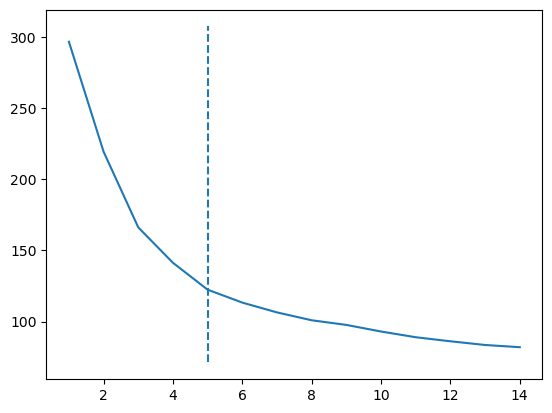

[1.3619877  0.8999862  1.35699697 0.47603206 1.04749551]
color palegreen , resi 0+1+2+3+4+5+6+12+15+16+17+18+19+20+21+24+25+26+31+32+33+38+43+44+45+49+50+51+52+53+54+55+56+57+58+59+60+61+62+63+64+65+66+67+68+69+87+88+90+91+92+93+98+99+100+101+102
color red , resi 34+35+36+37+39+40+41+42+70+71+72+73+74+75+76+77
color lightpink , resi 7+8+9+10+11+22+23+27+28+29+30+78+79+80+81+82+83
color blue , resi 103+104+105+106+107+108+109+110+111+112+113
color lightblue , resi 13+14+46+47+48+84+85+86+89+94+95+96+97


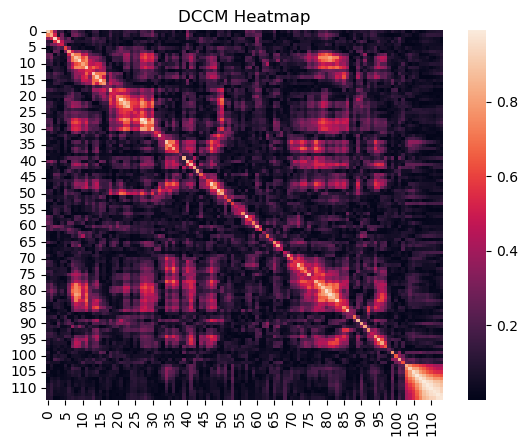

<Figure size 1300x1500 with 0 Axes>

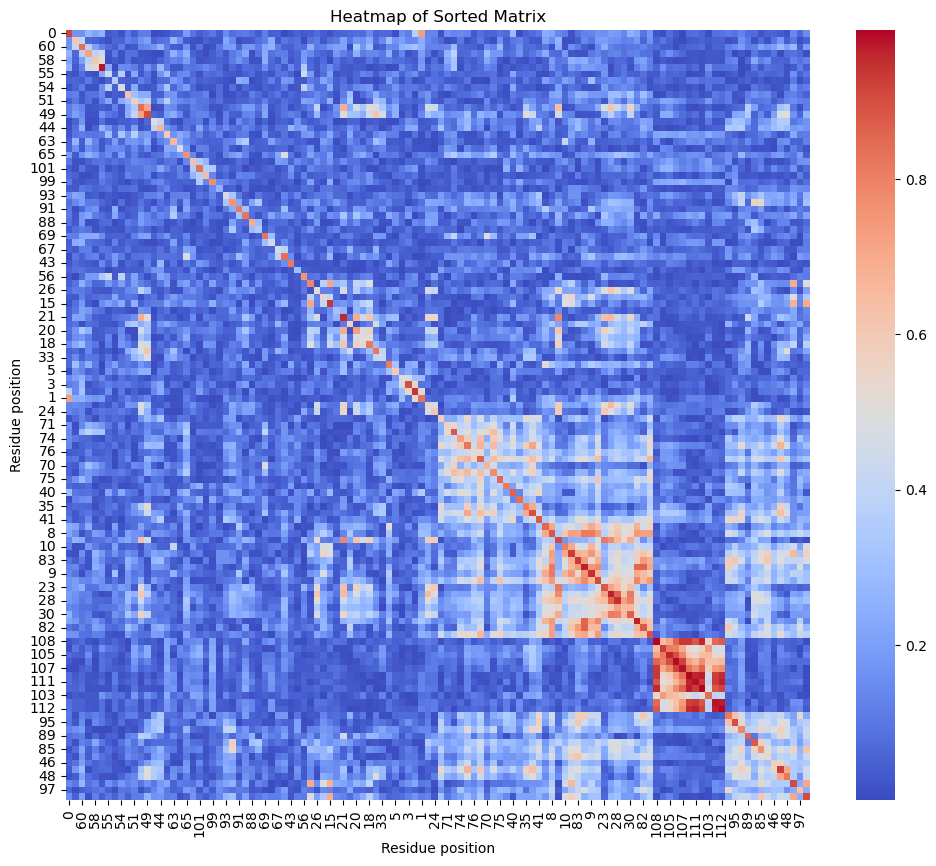

In [8]:
# Convert it to a NumPy array if it's not already
dccm_numpy = np.abs(dccm.cpu().numpy())

wcss = []
for i in range(1, 15):
    kmeans = KMeans(n_clusters=i, init='random', random_state=0,n_init='auto')
    kmeans.fit(dccm_numpy)
    wcss.append(kmeans.inertia_)
# Find the knee point using the KneeLocator module
kl = KneeLocator(range(1, 15), wcss, curve='convex', direction='decreasing')
knee = kl.elbow
plt.plot(range(1, 15), wcss)
plt.vlines(knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
plt.show()

# Apply KMeans clustering
kmeans = KMeans(n_clusters=knee, random_state=0,n_init='auto').fit(dccm_numpy)
# Get the cluster assignments for each residue
clusters = kmeans.labels_
# print(clusters)


# Initialize an array to store the WCSS for each cluster
wcss_clusters = np.zeros(knee)
# Calculate WCSS for each cluster
for i in range(knee):
    # Extract points belonging to cluster i
    cluster_points = dccm_numpy[clusters == i]
    # Calculate squared distances to the cluster centroid
    wcss_clusters[i] = np.sum((cluster_points - kmeans.cluster_centers_[i])**2)/len(cluster_points)
# wcss_clusters now contains the WCSS for each cluster
print(wcss_clusters)



intense_colors=iter(['red','blue','green','tv_orange','purple'])
pale_colors=iter(['palegreen','lightpink','lightblue','lightorange'])
for i in range(knee):
    if wcss_clusters[i] < 1:
        print('color',next(intense_colors),', resi','+'.join(list(map(lambda x:str(x),list(np.where(clusters == i)[0])))))
    else:
        print('color',next(pale_colors),', resi','+'.join(list(map(lambda x:str(x),list(np.where(clusters == i)[0])))))

# Create a clustered heatmap
sns.heatmap(dccm_numpy)
# sns.clustermap(dccm_numpy, method='centroid', cmap='coolwarm', figsize=(10, 10), vmin=0, vmax=1)
# Add the main title
plt.title('DCCM Heatmap')
# Show the plot
plt.figure(figsize=(13, 15))
plt.show()

# Create a sorted index based on clusters
sorted_indices = np.argsort(clusters)
# Sort rows and columns of the matrix according to the sorted indices
sorted_matrix = dccm_numpy[sorted_indices, :][:, sorted_indices]
# Creating the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(sorted_matrix, cmap='coolwarm')
# To avoid crowding, we can display only every 10th label
tick_frequency = 2
selected_ticks = np.arange(0, len(sorted_indices), tick_frequency)
selected_labels = sorted_indices[selected_ticks]
plt.xticks(ticks=selected_ticks + 0.5, labels=selected_labels, rotation=90)
plt.yticks(ticks=selected_ticks + 0.5, labels=selected_labels, rotation=0)
plt.title("Heatmap of Sorted Matrix")
plt.xlabel("Residue position")
plt.ylabel("Residue position")
plt.show()

0787221864

## 